In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount = False)

Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/MyDrive/Mediapipe dataset.zip'

unzip:  cannot find or open /content/drive/MyDrive/Mediapipe dataset.zip, /content/drive/MyDrive/Mediapipe dataset.zip.zip or /content/drive/MyDrive/Mediapipe dataset.zip.ZIP.


In [ ]:
!pip install mediapipe

In [ ]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
import os
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Intializing the Mediapipe Model

In [ ]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils

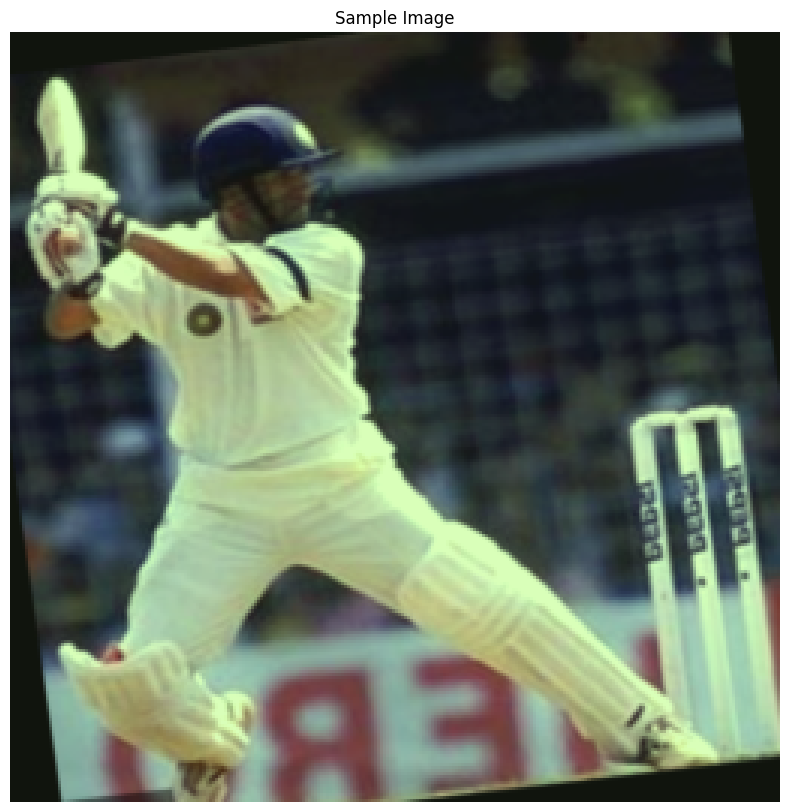

In [ ]:
# Read an image from the specified path.
sample_img = cv2.imread('/content/Mediapipe dataset/test/sc/augmented_10_2.png')
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
# Specify a size of the figure.
plt.figure(figsize = [10, 10])

# Display the sample image, also convert BGR to RGB for display.
plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img);plt.show()

# Performing Pose Detection

In [ ]:
results = pose.process(sample_img)
# Check if any landmarks are found.
if results.pose_landmarks:
    # Iterate two times as we only want to display first two landmarks.
    for i in range(2):
        # Display the found normalized landmarks.
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}')


NOSE:
x: 0.36466044187545776
y: 0.21389707922935486
z: -0.14215624332427979
visibility: 0.9999721050262451

LEFT_EYE_INNER:
x: 0.360859215259552
y: 0.19025391340255737
z: -0.12236852198839188
visibility: 0.9999271631240845



In [ ]:
image_height, image_width, _ = sample_img.shape
# Check if any landmarks are found.
if results.pose_landmarks:

    # Iterate two times as we only want to display first two landmark.
    for i in range(32):

        # Display the found landmarks after converting them into their original scale.
        print(f'{mp_pose.PoseLandmark(i).name}:')
        print(f'x: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x * image_width}')
        print(f'y: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y * image_height}')
        print(f'z: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z * image_width}')
        print(f'visibility: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].visibility}\n')

NOSE:
x: 93.35307312011719
y: 54.757652282714844
z: -36.391998291015625
visibility: 0.9999721050262451

LEFT_EYE_INNER:
x: 92.37995910644531
y: 48.70500183105469
z: -31.32634162902832
visibility: 0.9999271631240845

LEFT_EYE:
x: 92.57720184326172
y: 48.633392333984375
z: -31.43671989440918
visibility: 0.9998929500579834

LEFT_EYE_OUTER:
x: 92.7614517211914
y: 48.6044921875
z: -31.433000564575195
visibility: 0.9999245405197144

RIGHT_EYE_INNER:
x: 88.31559753417969
y: 49.83324432373047
z: -32.423282623291016
visibility: 0.9999533891677856

RIGHT_EYE:
x: 85.73432159423828
y: 50.50183868408203
z: -32.53804397583008
visibility: 0.9999363422393799

RIGHT_EYE_OUTER:
x: 83.72582244873047
y: 51.01686096191406
z: -32.593990325927734
visibility: 0.9999592304229736

LEFT_EAR:
x: 88.2111587524414
y: 50.9881591796875
z: -1.3325639963150024
visibility: 0.9999613761901855

RIGHT_EAR:
x: 79.78538513183594
y: 53.48918914794922
z: -6.117352485656738
visibility: 0.9999345541000366

MOUTH_LEFT:
x: 91.2273

# Drawing the detected landmarks images

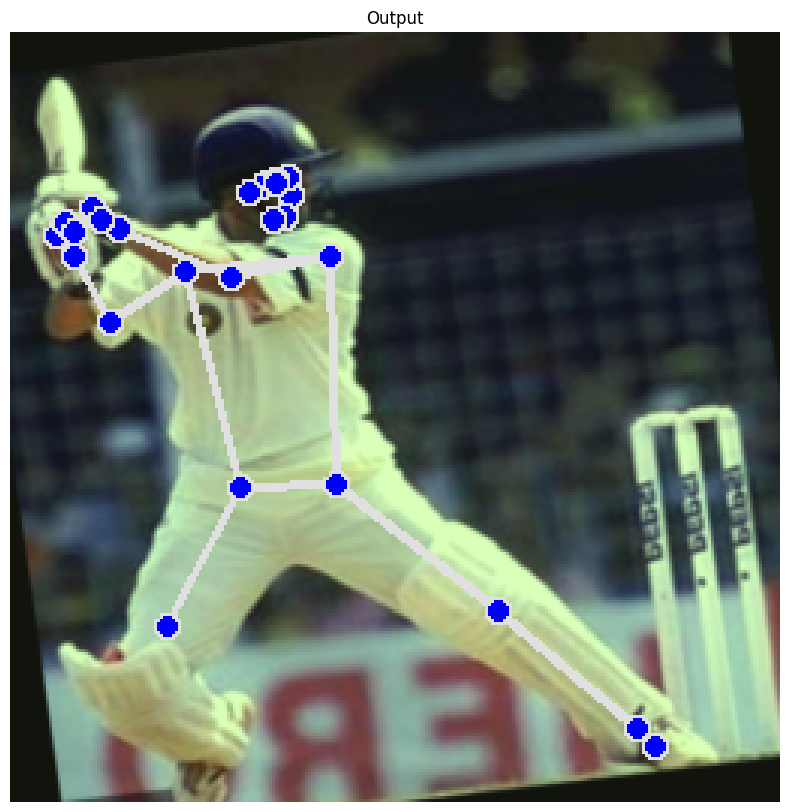

In [ ]:
# Create a copy of the sample image to draw landmarks on.
img_copy = sample_img.copy()

# Check if any landmarks are found.
if results.pose_landmarks:

    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)

    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display.
    plt.title("Output");plt.axis('off');plt.imshow(img_copy);plt.show()

# Displaying the Landmarks in 3D

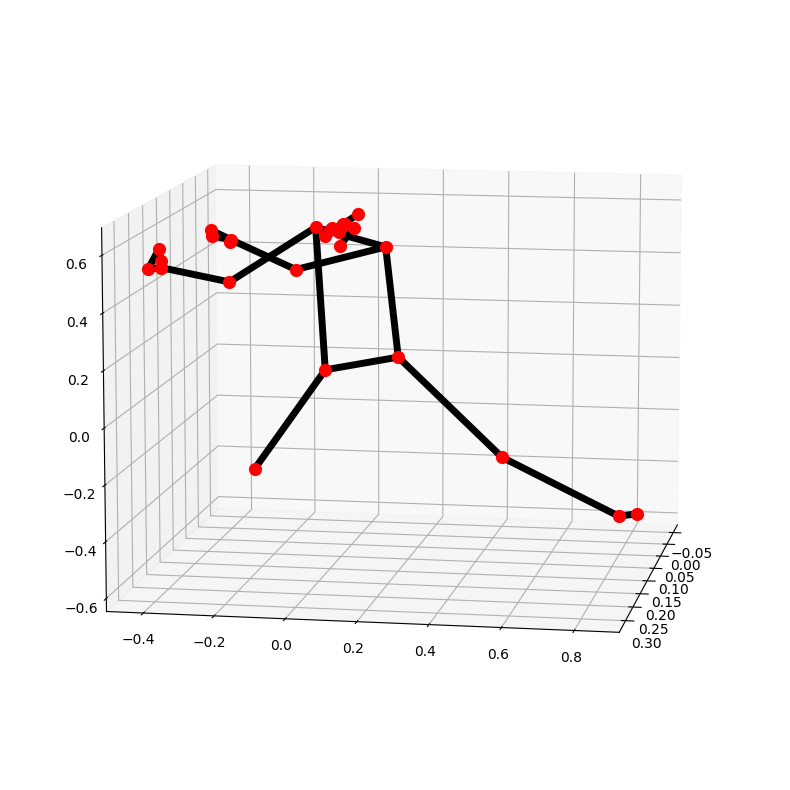

In [ ]:
# Plot Pose landmarks in 3D
mp_drawing.plot_landmarks(results.pose_world_landmarks,mp_pose.POSE_CONNECTIONS)

# Pose Detection Function

In [ ]:
import cv2
import mediapipe as mp
import os
import pandas as pd

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def detectPose(image, pose, display=True):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image,
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of dictionaries representing the detected landmarks with name, x, y, and score.
    '''

    # Create a copy of the input image.
    output_image = image.copy()

    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform the Pose Detection.
    results = pose.process(imageRGB)

    # Retrieve the height and width of the input image.
    height, width, _ = image.shape

    # Initialize a list to store the detected landmarks.
    landmarks = []

    # Check if any landmarks are detected.
    if results.pose_landmarks:
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)

        # Iterate over the detected landmarks.
        for idx, landmark in enumerate(results.pose_landmarks.landmark):
            # Append the landmark into the list as a dictionary with name, x, y, and score.
            landmarks.append({
                'name': mp_pose.PoseLandmark(idx).name,
                'x': landmark.x * width,
                'y': landmark.y * height,
                'score': landmark.visibility
            })

    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22, 22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');

        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

    # Otherwise
    else:
        # Return the output image and the found landmarks.
        return output_image, landmarks


In [ ]:
def landmarks_list_to_df(landmarks):
    # Convert the list of dictionaries to a DataFrame
    landmarks_df = pd.DataFrame(landmarks)

    # Initialize an empty list to store the transformed data
    transformed_data = []

    # Loop through each row of the DataFrame
    for index, row in landmarks_df.iterrows():
        transformed_row = dict()
        for landmark in row:
            if landmark is not None:
                name_x = landmark['name']+"_x"
                name_y = landmark['name']+'_y'
                name_score = landmark['name']+'_score'
                transformed_row[name_x] = landmark['x']
                transformed_row[name_y] = landmark['y']
                transformed_row[name_score] = landmark['score']
        transformed_data.append(transformed_row)

        # print()
    # Convert the transformed data list to a DataFrame
    landmarks_df_transformed = pd.DataFrame(transformed_data)
    return landmarks_df_transformed

Parsing through the dataset

In [ ]:
def create_landmarks_dataframe(dataset_dir, pose):
    image_paths_train = []
    image_paths_test = []
    landmarks_train = []
    landmarks_test = []
    pose_name_train = []
    pose_name_test = []
    class_labels = {}
    class_label_counter = 0
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_path = os.path.join(root, file)
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                istrain = root.split(os.path.sep)[-2]
                o_img, landmark = detectPose(img, pose, display=False)
                if len(landmark)==0:
                    print(image_path)
                    print(landmark)
                    print()

                if landmark:
                    if istrain == 'train':
                        image_paths_train.append(image_path)
                        landmarks_train.append(landmark)
                        folder_name = root.split(os.path.sep)[-1]
                        pose_name_train.append(folder_name)
                        if folder_name not in class_labels:
                            class_labels[folder_name] = class_label_counter
                            class_label_counter += 1
                    else:
                        image_paths_test.append(image_path)
                        landmarks_test.append(landmark)
                        folder_name = root.split(os.path.sep)[-1]
                        pose_name_test.append(folder_name)
                        if folder_name not in class_labels:
                            class_labels[folder_name] = class_label_counter
                            class_label_counter += 1

    landmarks_train_df = landmarks_list_to_df(landmarks_train)
    landmarks_test_df = landmarks_list_to_df(landmarks_test)

    train_df = pd.DataFrame({'path': image_paths_train, 'pose_name': pose_name_train})
    test_df = pd.DataFrame({'path': image_paths_test, 'pose_name': pose_name_test})

    train_df['label'] = train_df['pose_name'].map(class_labels)
    test_df['label'] = test_df['pose_name'].map(class_labels)

    # # Combine the DataFrames horizontally
    train_combined_df = pd.concat([train_df, landmarks_train_df], axis=1)
    test_combined_df = pd.concat([test_df, landmarks_test_df], axis=1)

    return train_combined_df, test_combined_df


In [ ]:
train_df, test_df = create_landmarks_dataframe('/content/Mediapipe dataset', pose)

/content/dt/train/sd/a image_0_1445.jpeg
[]

/content/dt/train/sd/a image_0_5952.jpeg
[]

/content/dt/train/sd/a image_0_7817.jpeg
[]

/content/dt/train/sd/a image_0_7756.jpeg
[]

/content/dt/train/sd/a image_0_9384.jpeg
[]

/content/dt/train/sd/a image_0_1044.jpeg
[]

/content/dt/train/sd/a image_0_7308.jpeg
[]

/content/dt/train/sd/a image_0_6593.jpeg
[]

/content/dt/train/sd/a image_0_8419.jpeg
[]

/content/dt/train/sd/a image_0_6390.jpeg
[]

/content/dt/train/sd/a image_0_799.jpeg
[]

/content/dt/train/sd/a image_0_5323.jpeg
[]

/content/dt/train/sd/a image_0_5610.jpeg
[]

/content/dt/train/sd/a image_0_4960.jpeg
[]

/content/dt/train/sd/a image_0_4213.jpeg
[]

/content/dt/train/sd/a image_0_4584.jpeg
[]

/content/dt/train/sd/a image_0_4939.jpeg
[]

/content/dt/train/sd/a image_0_8335.jpeg
[]

/content/dt/train/sd/a image_0_9951.jpeg
[]

/content/dt/train/sd/a image_0_3207.jpeg
[]

/content/dt/train/sd/a image_0_9398.jpeg
[]

/content/dt/train/sd/a image_0_8671.jpeg
[]

/content/dt

In [ ]:
null_values_count = train_df.isnull().sum()
print(null_values_count)

path                      0
pose_name                 0
label                     0
NOSE_x                    0
NOSE_y                    0
                         ..
LEFT_FOOT_INDEX_y         0
LEFT_FOOT_INDEX_score     0
RIGHT_FOOT_INDEX_x        0
RIGHT_FOOT_INDEX_y        0
RIGHT_FOOT_INDEX_score    0
Length: 102, dtype: int64


In [ ]:
null_values_count = test_df.isnull().sum()
print(null_values_count)

path                      0
pose_name                 0
label                     0
NOSE_x                    0
NOSE_y                    0
                         ..
LEFT_FOOT_INDEX_y         0
LEFT_FOOT_INDEX_score     0
RIGHT_FOOT_INDEX_x        0
RIGHT_FOOT_INDEX_y        0
RIGHT_FOOT_INDEX_score    0
Length: 102, dtype: int64


In [ ]:
def load_pose_landmarks(dataframe):
  """Loads a CSV created by MoveNetPreprocessor.

  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['path'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('pose_name').unique()

  # Extract the labels
  y = df_to_process.pop('label')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

Epoch 1/50
44/44 [==============================] - 7s 9ms/step - loss: 10.3124 - accuracy: 0.5833 - val_loss: 6.8135 - val_accuracy: 0.4615
Epoch 2/50
44/44 [==============================] - 0s 4ms/step - loss: 2.2041 - accuracy: 0.6480 - val_loss: 5.4260 - val_accuracy: 0.3974
Epoch 3/50
44/44 [==============================] - 0s 4ms/step - loss: 1.7244 - accuracy: 0.6552 - val_loss: 2.9544 - val_accuracy: 0.6538
Epoch 4/50
44/44 [==============================] - 0s 4ms/step - loss: 1.5752 - accuracy: 0.6351 - val_loss: 4.6575 - val_accuracy: 0.4615
Epoch 5/50
44/44 [==============================] - 0s 4ms/step - loss: 0.8926 - accuracy: 0.7170 - val_loss: 4.2003 - val_accuracy: 0.1923
Epoch 6/50
44/44 [==============================] - 0s 5ms/step - loss: 0.8872 - accuracy: 0.7399 - val_loss: 4.3481 - val_accuracy: 0.5000
Epoch 7/50
44/44 [==============================] - 0s 5ms/step - loss: 0.8114 - accuracy: 0.7399 - val_loss: 4.5820 - val_accuracy: 0.2949
Epoch 8/50
44/44 [=

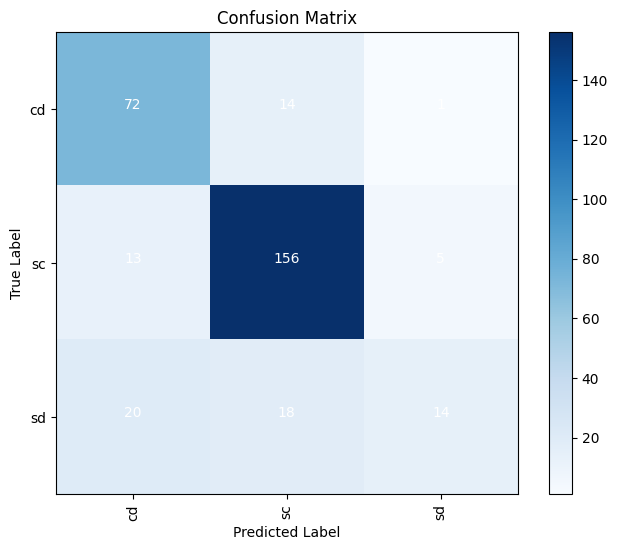

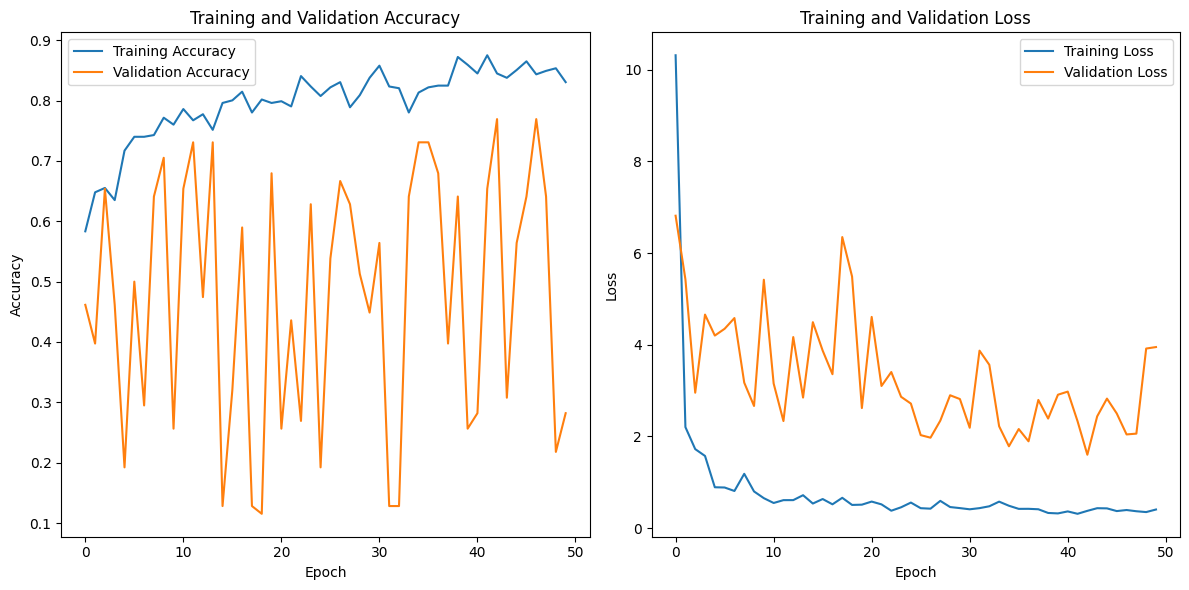

In [ ]:
X_train, y_train, class_names_train, _ = load_pose_landmarks(train_df)
X_test, y_test, class_names_test, _ = load_pose_landmarks(test_df)
# Combine the train and test class names to ensure consistency
class_names = np.unique(np.concatenate((class_names_train, class_names_test), axis=0))

# Build the neural network model
input_shape = X_train.shape[1:]
num_classes = len(class_names)

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=input_shape),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model with learning rate
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model and store the training history
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to class names
y_test_labels = np.argmax(y_test, axis=1)

# Display classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=class_names))

# Display confusion matrix with numbers inside
confusion_mtx = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)

# Add numbers inside the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(confusion_mtx[i, j]), horizontalalignment="center", color="white")

plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

Epoch 1/100
87/87 [==============================] - 2s 6ms/step - loss: 7.0433 - accuracy: 0.5790 - val_loss: 5.0626 - val_accuracy: 0.4872
Epoch 2/100
87/87 [==============================] - 0s 4ms/step - loss: 3.3382 - accuracy: 0.5977 - val_loss: 10.2305 - val_accuracy: 0.0385
Epoch 3/100
87/87 [==============================] - 0s 4ms/step - loss: 2.1386 - accuracy: 0.6509 - val_loss: 10.7120 - val_accuracy: 0.1154
Epoch 4/100
87/87 [==============================] - 0s 4ms/step - loss: 1.6766 - accuracy: 0.6810 - val_loss: 7.3684 - val_accuracy: 0.0513
Epoch 5/100
87/87 [==============================] - 0s 4ms/step - loss: 1.7559 - accuracy: 0.6652 - val_loss: 12.2632 - val_accuracy: 0.0128
Epoch 6/100
87/87 [==============================] - 0s 4ms/step - loss: 0.9624 - accuracy: 0.7213 - val_loss: 4.2782 - val_accuracy: 0.4872
Epoch 7/100
87/87 [==============================] - 0s 4ms/step - loss: 1.0117 - accuracy: 0.7170 - val_loss: 4.4807 - val_accuracy: 0.2436
Epoch 8/10

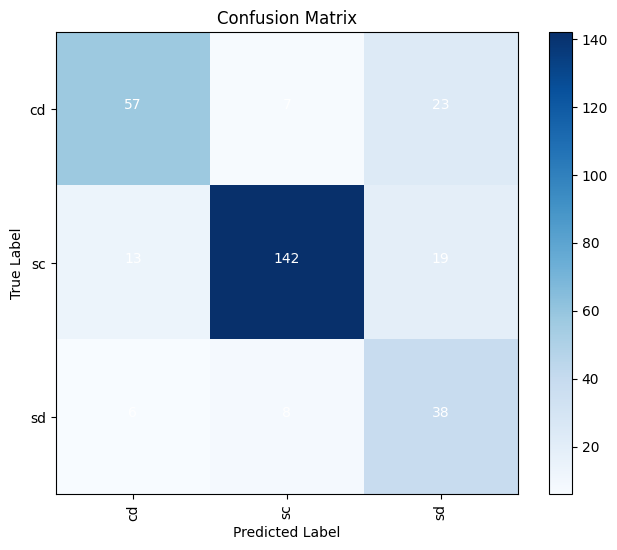

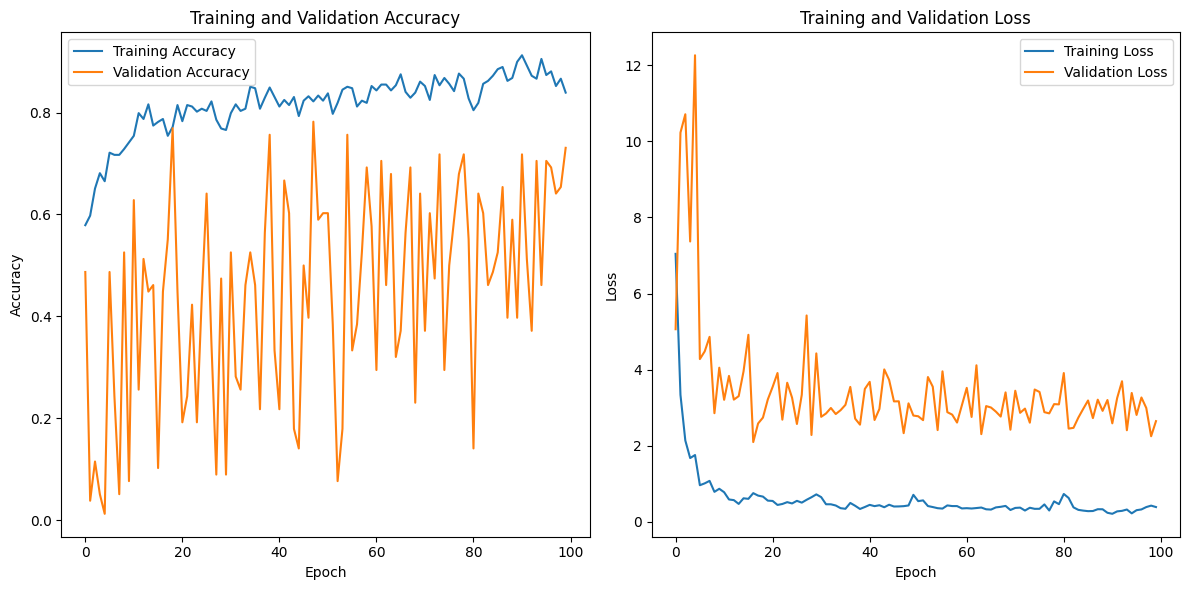

In [ ]:
X_train, y_train, class_names_train, _ = load_pose_landmarks(train_df)
X_test, y_test, class_names_test, _ = load_pose_landmarks(test_df)
# Combine the train and test class names to ensure consistency
class_names = np.unique(np.concatenate((class_names_train, class_names_test), axis=0))

# Build the neural network model
input_shape = X_train.shape[1:]
num_classes = len(class_names)

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=input_shape),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model with learning rate
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model and store the training history
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to class names
y_test_labels = np.argmax(y_test, axis=1)

# Display classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=class_names))

# Display confusion matrix with numbers inside
confusion_mtx = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)

# Add numbers inside the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(confusion_mtx[i, j]), horizontalalignment="center", color="white")

plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

Epoch 1/200
87/87 [==============================] - 2s 6ms/step - loss: 9.3978 - accuracy: 0.5589 - val_loss: 16.6481 - val_accuracy: 0.1026
Epoch 2/200
87/87 [==============================] - 0s 4ms/step - loss: 4.7836 - accuracy: 0.6264 - val_loss: 18.2028 - val_accuracy: 0.0256
Epoch 3/200
87/87 [==============================] - 0s 4ms/step - loss: 3.1181 - accuracy: 0.6580 - val_loss: 21.0601 - val_accuracy: 0.0769
Epoch 4/200
87/87 [==============================] - 0s 4ms/step - loss: 2.1854 - accuracy: 0.6825 - val_loss: 11.8713 - val_accuracy: 0.0769
Epoch 5/200
87/87 [==============================] - 0s 6ms/step - loss: 2.1029 - accuracy: 0.6652 - val_loss: 7.7265 - val_accuracy: 0.1923
Epoch 6/200
87/87 [==============================] - 1s 6ms/step - loss: 1.5778 - accuracy: 0.7055 - val_loss: 7.6570 - val_accuracy: 0.0897
Epoch 7/200
87/87 [==============================] - 1s 6ms/step - loss: 1.2695 - accuracy: 0.6997 - val_loss: 15.0581 - val_accuracy: 0.0513
Epoch 8/

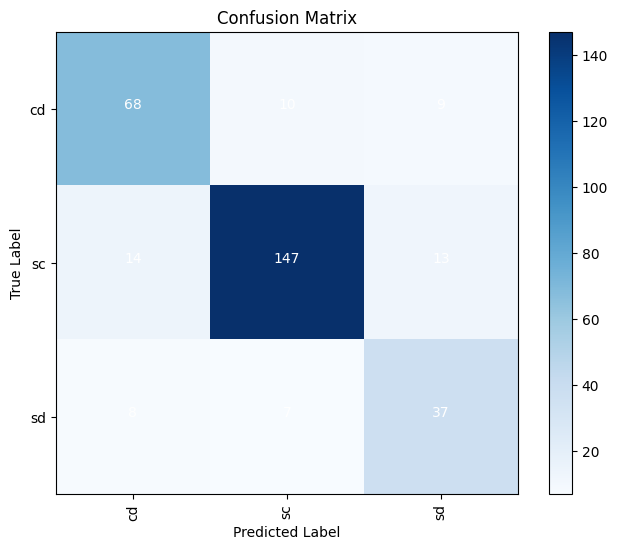

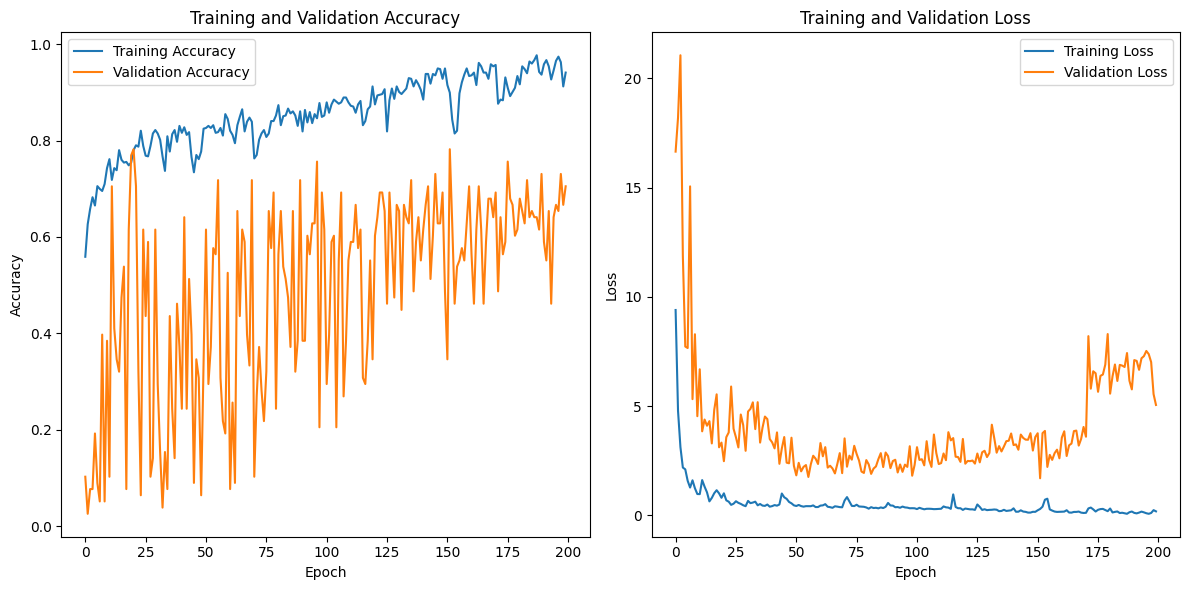

In [ ]:
X_train, y_train, class_names_train, _ = load_pose_landmarks(train_df)
X_test, y_test, class_names_test, _ = load_pose_landmarks(test_df)
# Combine the train and test class names to ensure consistency
class_names = np.unique(np.concatenate((class_names_train, class_names_test), axis=0))

# Build the neural network model
input_shape = X_train.shape[1:]
num_classes = len(class_names)

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=input_shape),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model with learning rate
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model and store the training history
history = model.fit(X_train, y_train, epochs=200, batch_size=8, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to class names
y_test_labels = np.argmax(y_test, axis=1)

# Display classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=class_names))

# Display confusion matrix with numbers inside
confusion_mtx = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)

# Add numbers inside the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(confusion_mtx[i, j]), horizontalalignment="center", color="white")

plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
X_train, y_train, class_names_train, _ = load_pose_landmarks(train_df)
X_test, y_test, class_names_test, _ = load_pose_landmarks(test_df)
# Combine the train and test class names to ensure consistency
class_names = np.unique(np.concatenate((class_names_train, class_names_test), axis=0))

# Build the neural network model
input_shape = X_train.shape[1:]
num_classes = len(class_names)

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=input_shape),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model with learning rate
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model and store the training history
history = model.fit(X_train, y_train, epochs=200, batch_size=4, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to class names
y_test_labels = np.argmax(y_test, axis=1)

# Display classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=class_names))

# Display confusion matrix with numbers inside
confusion_mtx = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)

# Add numbers inside the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(confusion_mtx[i, j]), horizontalalignment="center", color="white")

plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

Epoch 1/200
155/155 [==============================] - 3s 5ms/step - loss: 8.2930 - accuracy: 0.6543 - val_loss: 26.8591 - val_accuracy: 0.0452
Epoch 2/200
155/155 [==============================] - 1s 4ms/step - loss: 3.0468 - accuracy: 0.7044 - val_loss: 32.6336 - val_accuracy: 0.0194
Epoch 3/200
155/155 [==============================] - 1s 4ms/step - loss: 2.0202 - accuracy: 0.7641 - val_loss: 14.9346 - val_accuracy: 0.0774
Epoch 4/200
155/155 [==============================] - 1s 4ms/step - loss: 1.3732 - accuracy: 0.7334 - val_loss: 27.8575 - val_accuracy: 0.0129
Epoch 5/200
155/155 [==============================] - 1s 5ms/step - loss: 1.2828 - accuracy: 0.7480 - val_loss: 20.3220 - val_accuracy: 0.0258
Epoch 6/200
155/155 [==============================] - 1s 6ms/step - loss: 0.9239 - accuracy: 0.7900 - val_loss: 14.9305 - val_accuracy: 0.0452
Epoch 7/200
155/155 [==============================] - 1s 7ms/step - loss: 0.5320 - accuracy: 0.8304 - val_loss: 21.1605 - val_accuracy: